# Assignment 1: Foundations Reflection

**Github link** - #adada

## Discriminative vs. Generative Models
This notebook implements and contrasts two fundamental AI model types on a simple, well‑known dataset (**MNIST**). A **logistic regression** classifier acts as our discriminative model, while a **basic generative adversarial network (GAN)** implemented using PyTorch serves as our generative model. By training these models on the same data, we can observe differences in their training dynamics, performance, and behavior.

### Importing Libraries

In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import torch                       # Main torch library
import torch.nn as nn              # neural network layers
import torch.optim as optim        # optimizers like Adam
from torch.utils.data import DataLoader   # loads data in batches
from torchvision import datasets, transforms

### Loading Dataset (MNIST)

In [21]:
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

mnist_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [22]:
X = mnist_train.data.numpy()
y = mnist_train.targets.numpy()

In [23]:
X.shape

(60000, 28, 28)

In [24]:
y.shape

(60000,)

### Visualising sample digits
This provides an intuition for the data we will feed into both models.  Each image is displayed as an 28×28 grid of grayscale pixels.

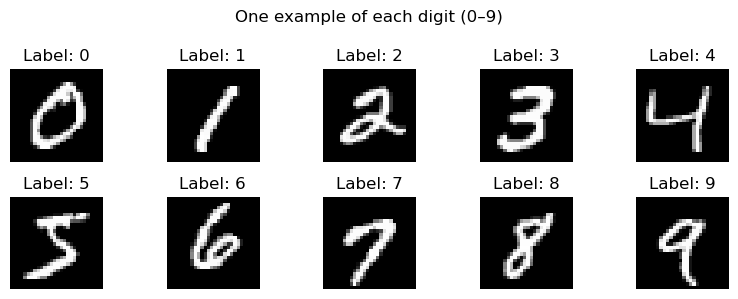

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))

for digit in range(10):
    idx = np.where(y == digit)[0][0]   # first index where label == digit
    ax = axes.flat[digit]
    ax.imshow(X[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {digit}")
    ax.axis("off")

plt.suptitle("One example of each digit (0–9)")
plt.tight_layout()
plt.show()

### Converts data from image format to table format

In [26]:
X_flat = X.reshape(-1, 28*28)

In [27]:
X_lg = X_flat/255.0

## **Logistic Regression**

Logistic regression is a linear classifier that models the probability of each class using a softmax function.  It is trained via maximum likelihood to separate classes based on input features.  Here we train it on a train/test split of the digits dataset and report standard classification metrics.

In [28]:
X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(
    X_lg, y, test_size= 0.3, random_state= 42, stratify= y
)

In [29]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_lg, y_train_lg)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [30]:
y_pred = log_reg.predict(X_test_lg)

accuracy = metrics.accuracy_score(y_test_lg,y_pred)
print("The accuracy score is:",accuracy)

The accuracy score is: 0.9183888888888889


In [31]:
print(metrics.classification_report(y_test_lg, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1777
           1       0.95      0.97      0.96      2023
           2       0.91      0.89      0.90      1787
           3       0.90      0.89      0.89      1839
           4       0.93      0.92      0.93      1753
           5       0.88      0.88      0.88      1626
           6       0.94      0.95      0.95      1775
           7       0.94      0.93      0.94      1880
           8       0.89      0.87      0.88      1755
           9       0.88      0.91      0.90      1785

    accuracy                           0.92     18000
   macro avg       0.92      0.92      0.92     18000
weighted avg       0.92      0.92      0.92     18000



### Confusion Matrix

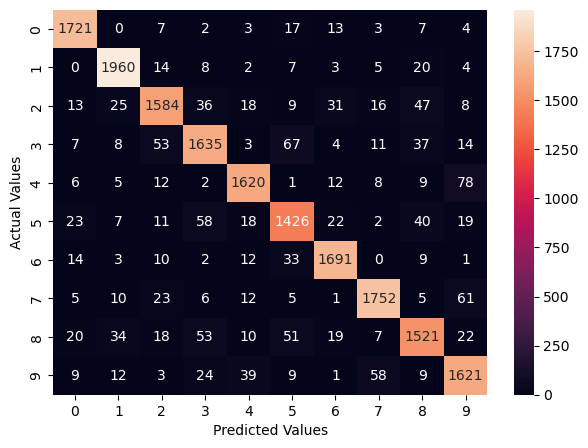

In [32]:
cm = metrics.confusion_matrix(y_test_lg, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Observations

Logistic regression achieves 92% accuracy, indicating strong classification performance. The majority of digits are correctly identified, with most errors occurring between visually similar digits. The model is stable, consistent, and easy to understand, making it an appropriate baseline classifier for this dataset.

## **GAN**

#### 1) Load MNIST for GAN

In [33]:
batch_size = 128       # Batch size = how many images we train on at a time
z_dim = 100            # z_dim = length of the random noise vector (input to generator)
lr = 0.0002            # Learning rate = step size for optimizer updates
num_epochs = 5         # Number of times we go through the full dataset


#  Normalize to [-1, 1]
transform_gan = transforms.Compose([
    transforms.ToTensor(),            # convert image to tensor in [0,1]
    transforms.Normalize((0.5,), (0.5,))   # [0,1] -> [-1,1]    # convert [0,1] to [-1,1]
])

# Download and load MNIST training set
mnist_gan = datasets.MNIST(root="./data", train=True, download=True, transform=transform_gan)
gan_loader = DataLoader(mnist_gan, batch_size=batch_size, shuffle=True, drop_last=True)   # DataLoader gives us batches of real images during training



#### 2) Define Generator and Discriminator

In [34]:
# Generator takes random noise and produces a fake 28x28 image.
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),  # noise to 256 features
            nn.ReLU(True),      # activation
            nn.Linear(256, 512),   # 256 to 512
            nn.ReLU(True), 
            nn.Linear(512, 28*28),  # 512 to 784 pixels
            nn.Tanh()  # output in [-1, 1]  # output in [-1,1]
        )
    def forward(self, z):
        x = self.net(z)    # create a flat 784-length vector
        return x.view(-1, 1, 28, 28)  # reshape into (batch, channel, height, width)

# Discriminator takes an image and outputs a probability
# 1 = real image, 0 = fake image

class Discriminator(nn.Module):  

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),    # 784 pixels to 512
            nn.LeakyReLU(0.2, True),  # activation
            nn.Linear(512, 256),       # 512 to 256
            nn.LeakyReLU(0.2, True),  
            nn.Linear(256, 1),       # 256 to 1 output
            nn.Sigmoid()  # convert to probability [0,1] which is real or fake
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)
        
# Create generator and discriminator 
G = Generator(z_dim)
D = Discriminator()

#### 3) Loss and Optimizers

In [35]:
# BCE Loss (Binary Cross Entropy) for real/fake classification
criterion = nn.BCELoss()

# Adam optimizer updates weights automatically
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

#### 4) Helper to show samples

In [36]:
# Fixed noise lets us track progress consistently
fixed_z = torch.randn(16, z_dim)

def show_samples(step_or_epoch, G):
    G.eval()    # turn off training mode for clean output
    with torch.no_grad():  # no gradients needed for generating samples
        fake = G(fixed_z).cpu()   # generate fake images
        fake = (fake + 1) / 2   # convert [-1,1] to [0,1] for plotting

    # Plot 16 images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(4, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake[i, 0], cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Generated Samples @ {step_or_epoch}")
    plt.tight_layout()
    plt.show()
    G.train()   # back to training mode

#### 5) Train GAN

Epoch 1/5 done. Last D loss=0.3199, Last G loss=2.7954


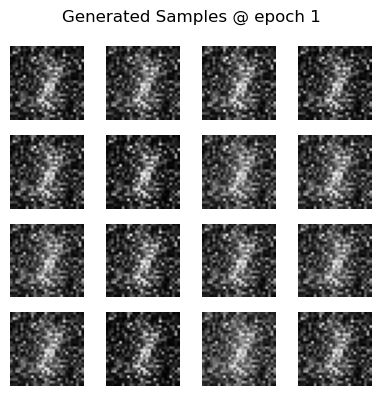

Step 500 | D loss: 0.2946 | G loss: 3.4783


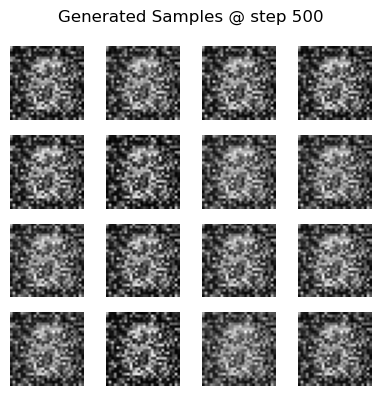

Epoch 2/5 done. Last D loss=0.2951, Last G loss=4.2074


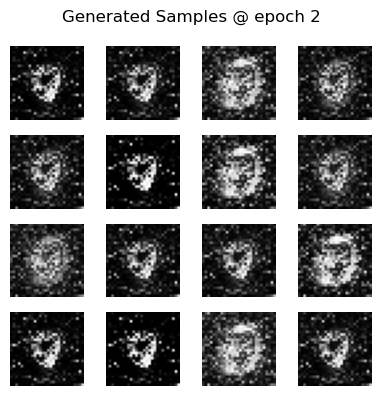

Step 1000 | D loss: 0.3444 | G loss: 2.4335


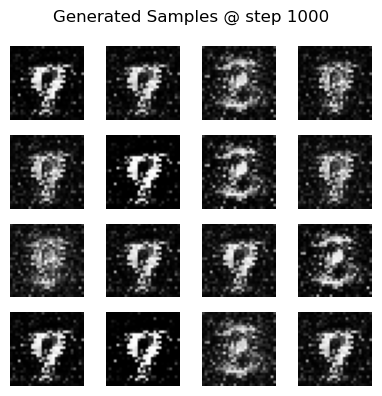

Epoch 3/5 done. Last D loss=0.8064, Last G loss=8.6173


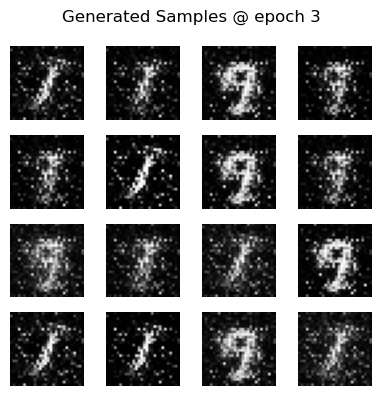

Step 1500 | D loss: 0.1086 | G loss: 4.3448


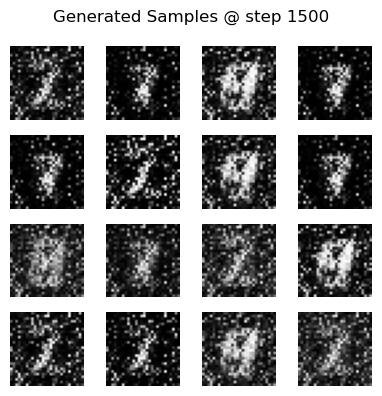

Epoch 4/5 done. Last D loss=0.2467, Last G loss=5.1674


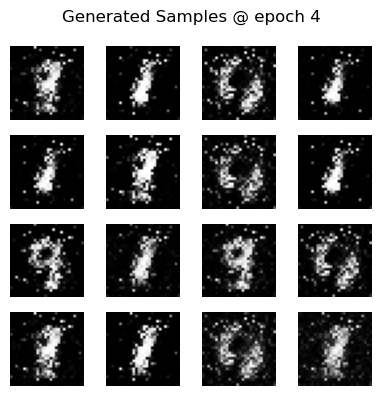

Step 2000 | D loss: 0.2212 | G loss: 3.5909


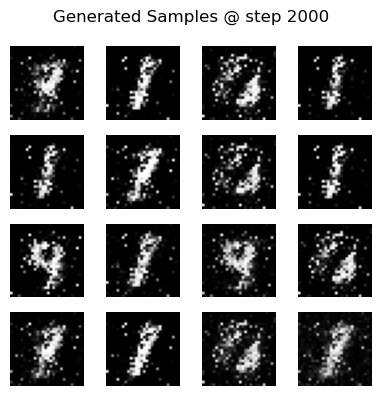

Epoch 5/5 done. Last D loss=0.2610, Last G loss=4.0615


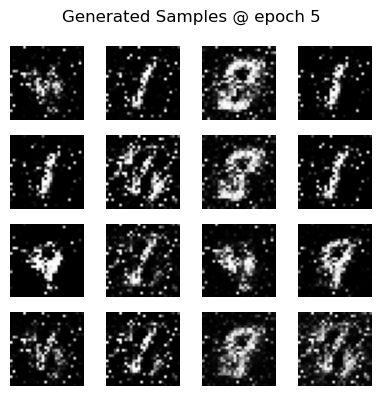

In [37]:
# Every batch we do TWO updates:
# 1) Train Discriminator: learn to detect fake images
# 2) Train Generator: learn to fool the discriminator

losses_D, losses_G = [], []
global_step = 0

for epoch in range(num_epochs):
    for real_imgs, _ in gan_loader:
        real_imgs = real_imgs
        bs = real_imgs.size(0)

        # Create labels:
        # real images is label 1
        # fake images is label 0
        real_labels = torch.ones(bs, 1)
        fake_labels = torch.zeros(bs, 1)
        
# Train Discriminator

        # Generate fake images
        z = torch.randn(bs, z_dim)
        fake_imgs = G(z).detach()  # detach so generator is NOT updated here
       
        
        # Discriminator tries to output:
        # D(real) -> 1
        # D(fake) -> 0
        opt_D.zero_grad()
        loss_D_real = criterion(D(real_imgs), real_labels)
        loss_D_fake = criterion(D(fake_imgs), fake_labels)
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        opt_D.step()

# Train Generator

         # Generate fake images again (this time generator WILL be updated)
        z = torch.randn(bs, z_dim)
        fake_imgs = G(z)

        opt_G.zero_grad()
        
        # Generator wants discriminator to think fakes are real:
        # D(fake) -> 1
        loss_G = criterion(D(fake_imgs), real_labels)
        loss_G.backward()
        opt_G.step()

        # Record losses for plotting
        losses_D.append(loss_D.item())
        losses_G.append(loss_G.item())
        global_step += 1

        # Show progress every 500 steps
        if global_step % 500 == 0:
            print(f"Step {global_step} | D loss: {loss_D.item():.4f} | G loss: {loss_G.item():.4f}")
            show_samples(f"step {global_step}", G)

     # After each epoch, show samples
    print(f"Epoch {epoch+1}/{num_epochs} done. Last D loss={loss_D.item():.4f}, Last G loss={loss_G.item():.4f}")
    show_samples(f"epoch {epoch+1}", G)

#### 6) Plot losses

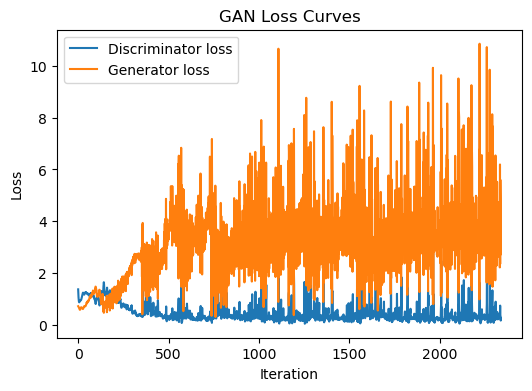

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(losses_D, label="Discriminator loss")
plt.plot(losses_G, label="Generator loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN Loss Curves")
plt.legend()
plt.show()

### Observations 
The GAN training was unstable, with losses changing rather than smoothly increasing. The discriminator learned quickly, whereas the generator struggled and gradually improved. The generated images became more digit-like over time, but they remained blurry and imperfect. Training was sensitive to hyperparameters, and performance had to be assessed visually rather than using a single metric. This shows the difficulty in training GANs and the adversarial nature of their learning process.

### Comparison and Reflection

Logistic regression and GAN work in very different ways. Logistic regression is simple and easy to train. It quickly learns to classify digits and gives a clear accuracy score of 92%, so we can easily measure how well it performs. The training process was smooth, and it was simple to see whether the model was improving or not.

GAN, on the other hand, is much more difficult. It has two models training at the same time, and they compete with each other. Because of this, training is unstable and the losses go up and down. There is no clear accuracy score, so we have to judge performance by looking at the generated images. The generator improves slowly and needs careful tuning of parameters.

Overall, logistic regression is best suited for classification tasks where the goal is to recognize patterns, while GANs are designed for generation tasks where the goal is to create new data. Generating data is more complex than classifying it, which explains why GANs are harder to train and require more experimentation.

### Conclusion

In this notebook, we explored the differences between a discriminative model and a generative model using logistic regression and a GAN. Logistic regression proved to be simple, stable, and easy to train, with clear performance evaluation through accuracy. It worked well for recognizing and classifying handwritten digits.
The GAN, on the other hand, was much more complex. Its training was unstable and sensitive to hyperparameters, and so we had to look at the generated images to judge its performance. However, it showed how a model can learn to create new data instead of only classifying existing data.
Overall, this comparison shows that discriminative models are well suited for tasks where the goal is prediction and classification, while generative models are better for tasks that require data creation and simulation. Although GANs are harder to train, they open the door to more creative and advanced applications in artificial intelligence.